In [77]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import legendre as L
from scipy.stats import beta

In [79]:
def norm_legendre(j): #returns normalized legendre defined on [0,1]
    return np.sqrt(2*j+1)*L.Legendre(degree(j), domain=[0,1])

In [80]:
def pdf_1_w(x, n):
    total=0
    for j in range(0,n+1):
        total+=norm_legendre(j)(x)**2
    return total/(n+1)

In [81]:
def l_2(x,i): #evaluates the square of the ith normalized legendre polynomial at the value x
    return (2*i+1)*(L.Legendre(degree(i), domain=[0,1])(x) )**2

- Using https://math.stackexchange.com/questions/1428311/how-to-show-that-any-legendre-polynomial-over-1-1-is-bounded-by-one-in-ab  Legendre polynomial are bounded in absolute value by 1

- We're considering the renormalized Legendre polynomials, hence the nth Legendre polynomial is bounded in absolute value by sqrt(2n+1)

- Hence the square of a Legendre polynomial is lower bounded by 0 and upper bounded by 2n+1


In order to sample from 1/w we will do rejection sampling (justify in the report why you're allowed to do that). The method can be found here: https://www.stats.ox.ac.uk/~rdavies/teaching/PartASSP/2020/lectures_latest/simulation_lecture3.pdf

- in the lecture notes it's called Acceptance-rejection but I liked better how it was explained in the link above



### Sampling using composition method and acceptance rejection with Beta(1/2, 1/2) as proposal distribution 

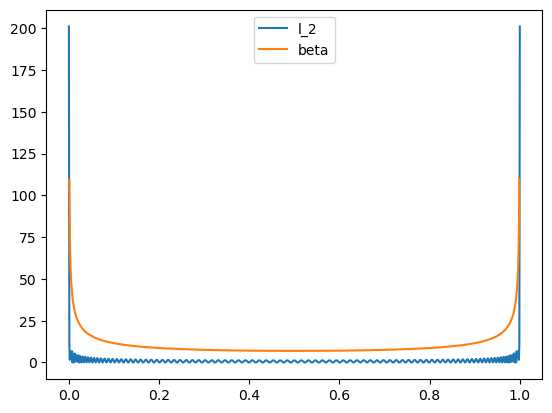

In [82]:
x=np.linspace(0, 1,1000) #evidence that 4e beta_pdf is a good upper bound for the nth Legendre polynomial independently
#of the value of n
a=1/2
up_bound=4*np.exp(1)
index=100

plt.plot(x, l_2(x, index), label="l_2")
plt.plot(x, up_bound*beta(a,a).pdf(x), label="beta")

plt.legend()
plt.show()

In [83]:
def gen_from_l_2(i, seed): #generating one random variables according to the ith legendre square distribution
    np.random.seed(seed)
    
    up_bound=4*np.exp(1) 
    
    #rejection sampling 
    
    Y_generated=-999
    V_generated=-999 #initial values, haven't been updated yet
    
    a=1/2
    
    while Y_generated==-999: #while there was no update
        Y=np.random.beta(a, a)
        V=np.random.uniform(low=0.0, high=1)
        if V<l_2(Y,i)/(up_bound*beta.pdf(Y, a,a)):
            Y_generated=Y
            V_generated=V
    return Y, V #Y is the value of interest to us, V is for visualisation purposes

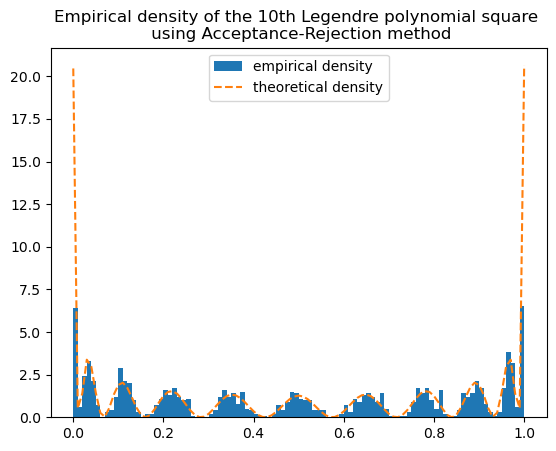

In [115]:
#histogram compared to the theoretical distribution 
#can be used for the oral presentation
index=10
M=1000
seed=9119

Y=[gen_from_l_2(index, m)[0] for m in range(M)]

_, bins, _=plt.hist(Y, density=True, bins=100, label="empirical density")
plt.plot(bins, l_2(bins, index), '--', label="theoretical density")
plt.title("Empirical density of the 10th Legendre polynomial square \n using Acceptance-Rejection method")
plt.legend()
plt.savefig("Figures/empirical_distribution_legendre_square.png")
plt.show()

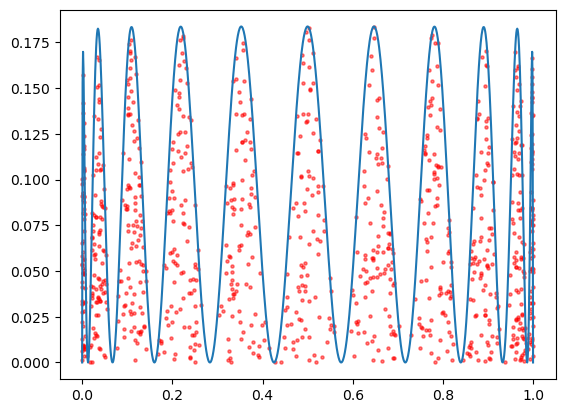

In [116]:
index=10 #numerically checking the values (Y, V) are correctly distributed
M=1000
x=np.linspace(0,1,1000)
a=1/2
l_2_list=l_2(x, index)/(up_bound*beta.pdf(x, a,a))

up_bound=4*np.exp(1)

gen_list=[gen_from_l_2(index, m) for m in range(M)]

Y=[value[0] for value in gen_list]
V=[value[1] for value in gen_list]

plt.plot(x, l_2_list)
plt.scatter(Y, V, alpha=0.5, s=5, color='red')
plt.show()

In [91]:
def gen_from_w(N, M, seed): #N the number of Legendre polynomials considered, M the number of wanted samples 
    
    np.random.seed(seed)
    
    Y_generated=[]
    
    for m in range(M): #we generate M random variables
        index=np.random.randint(0, high=N+1)
        Y, _=gen_from_l_2(index, m)
        Y_generated.append(Y) #using m as the seed to have a seed varying and for reproducibility
        
    return np.array(Y_generated)

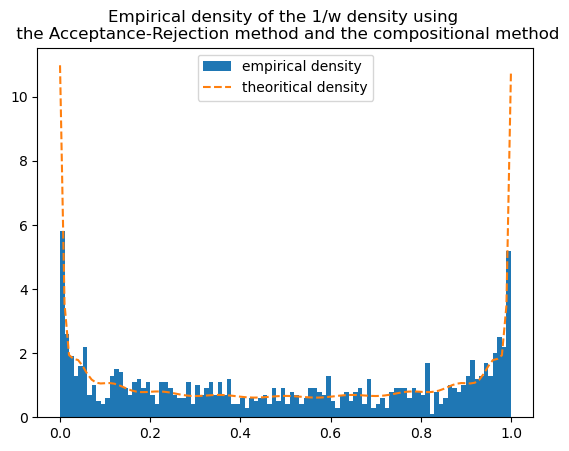

In [117]:
#histogram compared to the theoretical distribution 
#can be used for the oral presentation
N=10
M=1000
seed=9119

Y=gen_from_w(N, M, seed)

_, bins, _=plt.hist(Y, density=True, bins=100, label="empirical density")
plt.plot(bins, pdf_1_w(bins, N), '--', label="theoritical density")
plt.legend()
plt.title("Empirical density of the 1/w density using \n the Acceptance-Rejection method and the compositional method")
plt.savefig("Figures/empirical_distribution_1_w.png")
plt.show()

### MCLS with importance sampling

In [99]:
from helpers_1 import *

In [100]:
def V_mat(M, N, X):
    V=np.ones((M,N+1))
    for i in range(1,N+1):
        l_i=np.sqrt(2*i+1)*L.Legendre(degree(i), domain=[0,1]) #normalization coefficient to ensure orthonormality of
        #Legendre polynomials 
        V[:,i]=[l_i(x) for x in X]
    return V, np.linalg.cond(V)

In [107]:
def w(x, N):
    return 1/pdf_1_w(x, N)

In [110]:
def coefficient_importance(M, N, seed):
    np.random.seed(seed) #for reproducibility
    X=np.random.uniform(size=M)
    V, _=V_mat(M, N, X)
    f_eval=np.array([f(x) for x in X])
    
    X_tilde= gen_from_w(N, M, seed)
    W_tilde=np.diag([np.sqrt(w(x_tilde, N)) for x_tilde in X_tilde])
    
    V_tilde=W_tilde@V
    cond_V_tilde=np.linalg.cond(V_tilde)
    
    f_eval_tilde=W_tilde@f_eval
    
    c_coeff,_,_,_=np.linalg.lstsq(V_tilde,f_eval_tilde, rcond=10**(-5))
    return c_coeff, cond_V_tilde

In [111]:
def IMCLS_importance(M, N, seed_1, seed_2):
    
    np.random.seed(seed_1)
    X=np.random.uniform(size=M)
    c_coeff, cond_V=coefficient_importance(M, N, seed_2)
    l_array=lambda x,n: np.array([np.sqrt(2*j+1)*L.Legendre(degree(j), domain=[0,1])(x) for j in range(0,n+1)])
    f_array=np.array([f(x)-c_coeff@l_array(x, N) for x in X])
    
    IMCLS_value=np.mean(f_array)+c_coeff[0]
    IMCLS_prime_val=c_coeff[0]
    true_val=np.arctan(5)/5
    
    return np.abs(IMCLS_value-true_val), np.abs(true_val-IMCLS_prime_val), cond_V

KeyboardInterrupt: 

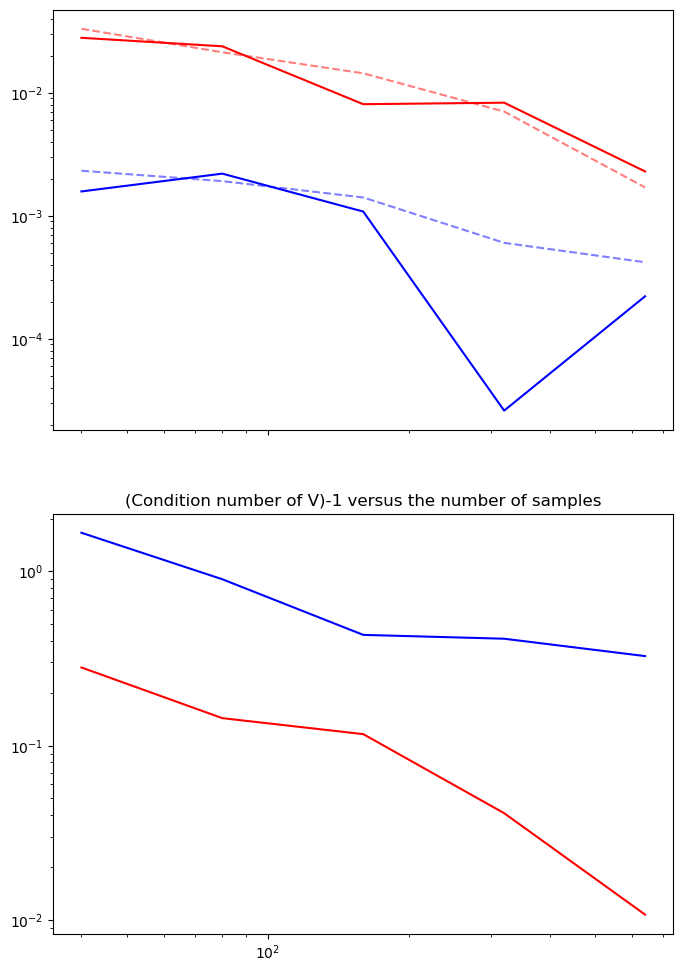

In [112]:
#all estimators have the same seed so that their performance doesn't depend on the sample drawn

fig, ax = plt.subplots(2,figsize= (8,12), sharey = False, sharex = True)

N=[1,5, 15, 30] #change to [1,5, 15, 30]
M_array=np.array([20*2**i for i in range(1,3)]) #modify to (1,6)

seed_1=9009
seed_2=1991

sbplt_0 = ax[0] #plot of the estimators
sbplt_1 = ax[1] #plot of the condition number
c=['red','blue', 'green', 'brown'] 
for i, n in enumerate(N):
    error_function_IMCLS_importance=[]
    error_function_IMCLS_importance_prime=[]
    cond_V_tilde=[]
    
    for m in M_array:
        e_IMCLS_importance, e_IMCLS_importance_prime, c_v_tilde=IMCLS_importance(m, n, seed_1, seed_2)
        cond_V_tilde.append(c_v_tilde-1)
        error_function_IMCLS_importance.append(e_IMCLS_importance)
        error_function_IMCLS_importance_prime.append(e_IMCLS_importance_prime)
           
    sbplt_0.loglog(M_array,error_function_IMCLS_importance, color=c[i], label="MCLS "+str(n))
    sbplt_0.loglog(M_array,error_function_IMCLS_importance_prime, alpha=0.5, color=c[i], linestyle='--', label="MCLS prime "+str(n))
    sbplt_1.loglog(M_array, cond_V_tilde, color=c[i], label='n='+str(n))
    sbplt_0.set_title("Estimation error of the MCLS and MCLS prime estimators \n for different values of N versus the number of samples")
    sbplt_1.set_title("Condition number of V -1 versus the number of samples")

#ploting O(M^{-1/2})
sbplt_0.loglog(M_array, M_array**-0.5, '-.',color='gray', label = r'$M^{-1/2}$')
        
sbplt_0.legend(loc='lower left', fontsize=8)
sbplt_0.set_xlabel("number of samples M")
sbplt_0.set_ylabel("error of the estimator")

sbplt_1.legend(loc='lower left', fontsize=8)
sbplt_1.set_xlabel("number of samples M")
sbplt_1.set_ylabel("cond(V)-1")

plt.title("plot of the error of the estimator and of the condition number of V -1")
plt.show()
        
fig.tight_layout()

#to save the figures separatly
extent_0 = sbplt_0.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
extent_1 = sbplt_1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
sbplt_0.figure.savefig("Figures/MCLS_and_prime_importance.png", bbox_inches=extent_0.expanded(1.3, 1.12))
sbplt_1.figure.savefig("Figures/condition_number_importance.png", bbox_inches=extent_1.expanded(1.3, 1.12))

finished with reference plots
40  doing with n depending on M
80  doing with n depending on M
160  doing with n depending on M
320  doing with n depending on M
640  doing with n depending on M


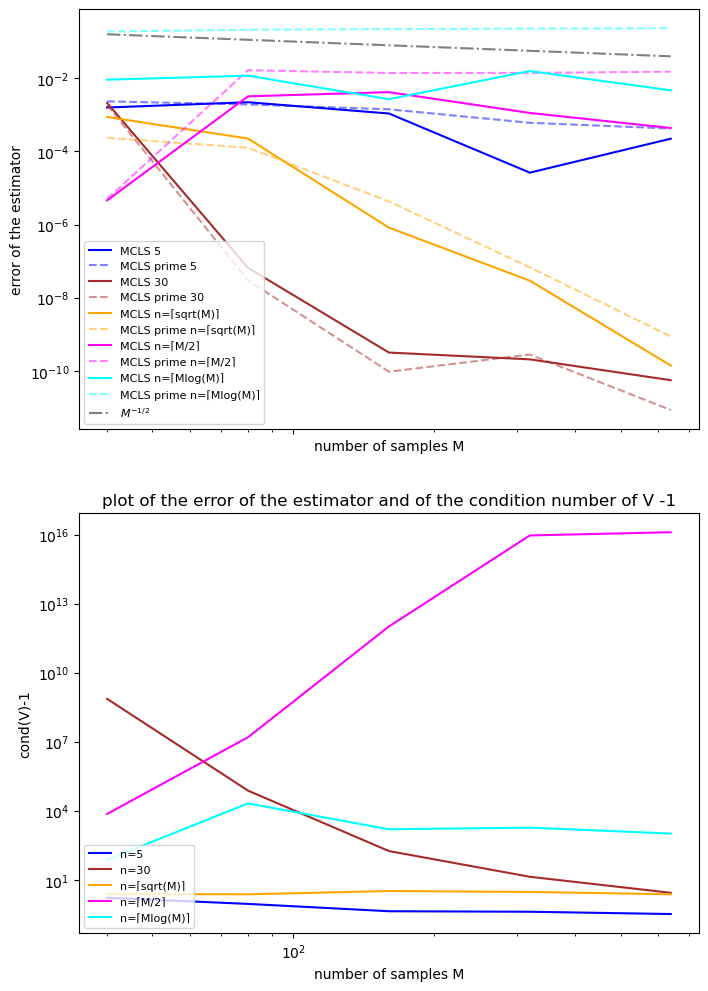

In [114]:
fig, ax = plt.subplots(2,figsize= (8,12), sharey = False, sharex = True)

N=[5, 30] #for reference/comparison to sqrt(M), M/2
M_array=np.array([20*2**i for i in range(1,3)]) #modify to (1,6) to check if all good- modify to (1,8) during night

seed_1=9009
seed_2=1991

sbplt_0 = ax[0] #plot of the estimators
sbplt_1 = ax[1] #plot of the condition number
c=['blue', 'brown']
for i, n in enumerate(N):
    error_function_IMCLS_importance=[]
    error_function_IMCLS_importance_prime=[]
    cond_V_tilde=[]
    
    for m in M_array:
        e_IMCLS_importance, e_IMCLS_importance_prime, c_v_tilde=IMCLS_importance(m, n, seed_1, seed_2)
        cond_V_tilde.append(c_v_tilde-1)
        error_function_IMCLS_importance.append(e_IMCLS_importance)
        error_function_IMCLS_importance_prime.append(e_IMCLS_importance_prime)
  
    sbplt_0.loglog(M_array,error_function_IMCLS_importance, color=c[i], label="MCLS "+str(n))
    sbplt_0.loglog(M_array,error_function_IMCLS_importance_prime, alpha=0.5, color=c[i], linestyle='--', label="MCLS prime "+str(n))
    sbplt_1.loglog(M_array, cond_V_tilde, color=c[i], label='n='+str(n))
    sbplt_0.set_title("Estimation error of the MCLS and MCLS prime estimators \n for different values of N versus the number of samples")
    sbplt_1.set_title("(Condition number of V)-1 versus the number of samples")

print("finished with reference plots")

#doing the same for n=⌈sqrt(M)⌉ and n=⌈M/2⌉ and n=⌈Mlog(M)⌉

N_func_1=lambda m: int(np.ceil(np.sqrt(m)))
N_func_2=lambda m: int(np.ceil(m/2))
N_func_3=lambda m: int(np.ceil(m*np.log(m))) #the natural logarithm
err_sqrt_M_importance=[]
err_sqrt_M_importance_prime=[]
err_M_2_importance=[]
err_M_2_importance_prime=[]
err_M_log_M_importance=[]
err_M_log_M_importance_prime=[]
cond_V_tilde_sqrt_M=[]
cond_V_tilde_M_2=[]
cond_V_tilde_M_log_M=[]

for m in M_array:
    e_sqrt_M_importance, e_sqrt_M_importance_prime, c_v_tilde_sqrt_M=IMCLS_importance(m, N_func_1(m), seed_1, seed_2)
    
    e_M_2_importance, e_M_2_importance_prime, c_v_tilde_M_2=IMCLS_importance(m, N_func_2(m), seed_1, seed_2)
    
    e_M_log_M_importance, e_M_log_M_importance_prime, c_v_tilde_M_log_M=IMCLS_importance(m, N_func_3(m), seed_1, seed_2)
    
    err_sqrt_M_importance.append(e_sqrt_M_importance)
    err_sqrt_M_importance_prime.append(e_sqrt_M_importance_prime)
    err_M_2_importance.append(e_M_2_importance)
    err_M_2_importance_prime.append(e_M_2_importance_prime)
    err_M_log_M_importance.append(e_M_log_M_importance)
    err_M_log_M_importance_prime.append(e_M_log_M_importance_prime)
    
    cond_V_tilde_sqrt_M.append(c_v_tilde_sqrt_M)
    cond_V_tilde_M_2.append(c_v_tilde_M_2)
    cond_V_tilde_M_log_M.append(c_v_tilde_M_log_M)
    
    print(m, " doing with n depending on M")

sbplt_0.loglog(M_array, err_sqrt_M_importance, color="orange", label='MCLS n=⌈sqrt(M)⌉')
sbplt_0.loglog(M_array, err_sqrt_M_importance_prime, color="orange", linestyle='--', alpha=0.5, label='MCLS prime n=⌈sqrt(M)⌉')
sbplt_0.loglog(M_array, err_M_2_importance, color="magenta", label='MCLS n=⌈M/2⌉')
sbplt_0.loglog(M_array, err_M_2_importance_prime, color="magenta", linestyle='--', alpha=0.5, label='MCLS prime n=⌈M/2⌉')
sbplt_0.loglog(M_array, err_M_log_M_importance, color="cyan", label='MCLS n=⌈Mlog(M)⌉')
sbplt_0.loglog(M_array, err_M_log_M_importance_prime, color="cyan", linestyle='--', alpha=0.5, label='MCLS prime n=⌈Mlog(M)⌉')
sbplt_1.loglog(M_array, cond_V_tilde_sqrt_M, color="orange", label="n=⌈sqrt(M)⌉")
sbplt_1.loglog(M_array, cond_V_tilde_M_2, color="magenta", label="n=⌈M/2⌉")
sbplt_1.loglog(M_array, cond_V_tilde_M_log_M, color="cyan", label="n=⌈Mlog(M)⌉")

#ploting O(M^{-1/2})
sbplt_0.loglog(M_array, M_array**-0.5, '-.',color='gray', label = r'$M^{-1/2}$')
        
sbplt_0.legend(loc='lower left', fontsize=8)
sbplt_0.set_xlabel("number of samples M")
sbplt_0.set_ylabel("error of the estimator")

sbplt_1.legend(loc='lower left', fontsize=8)
sbplt_1.set_xlabel("number of samples M")
sbplt_1.set_ylabel("cond(V)-1")

plt.title("plot of the error of the estimator and of the condition number of V -1")
plt.show()
        
fig.tight_layout()

#to save the figures separatly
extent_0 = sbplt_0.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
extent_1 = sbplt_1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
sbplt_0.figure.savefig("Figures/MCLS_and_prime_fun_n_importance.png", bbox_inches=extent_0.expanded(1.3, 1.12))
sbplt_1.figure.savefig("Figures/condition_number_fun_n_importance.png", bbox_inches=extent_1.expanded(1.3, 1.12))